In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGP, MORCGP_shared_noise, MOGPRegressor_NC_bounded_noise, MORCGP_bounded_noise, MOGPRegressor_bounded_noises, MORCGP_bounded_noises
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 18,    
    'xtick.labelsize': 22,   
    'ytick.labelsize': 22,  
    'legend.fontsize': 20,
    'lines.linewidth': 5,    
    'lines.markersize': 8   
})

In [2]:
df = pd.read_csv('navitoclax.csv')
df

,Unnamed: 0,cell_line,COSMIC_ID,drug,log10_dose,viability
0,1,22RV1,924100,Navitoclax,-2.6987,0.996820
1,2,22RV1,924100,Navitoclax,-2.3008,0.927539
2,3,22RV1,924100,Navitoclax,-2.1988,1.022289
3,4,22RV1,924100,Navitoclax,-1.9998,1.038805
4,5,22RV1,924100,Navitoclax,-1.8008,0.923463
...,...,...,...,...,...,...
17666,17667,no-11,908450,Navitoclax,-1.6988,0.906616
17667,17668,no-11,908450,Navitoclax,-1.1989,0.961543
17668,17669,no-11,908450,Navitoclax,-0.6989,0.896100
17669,17670,no-11,908450,Navitoclax,-0.1989,0.848893


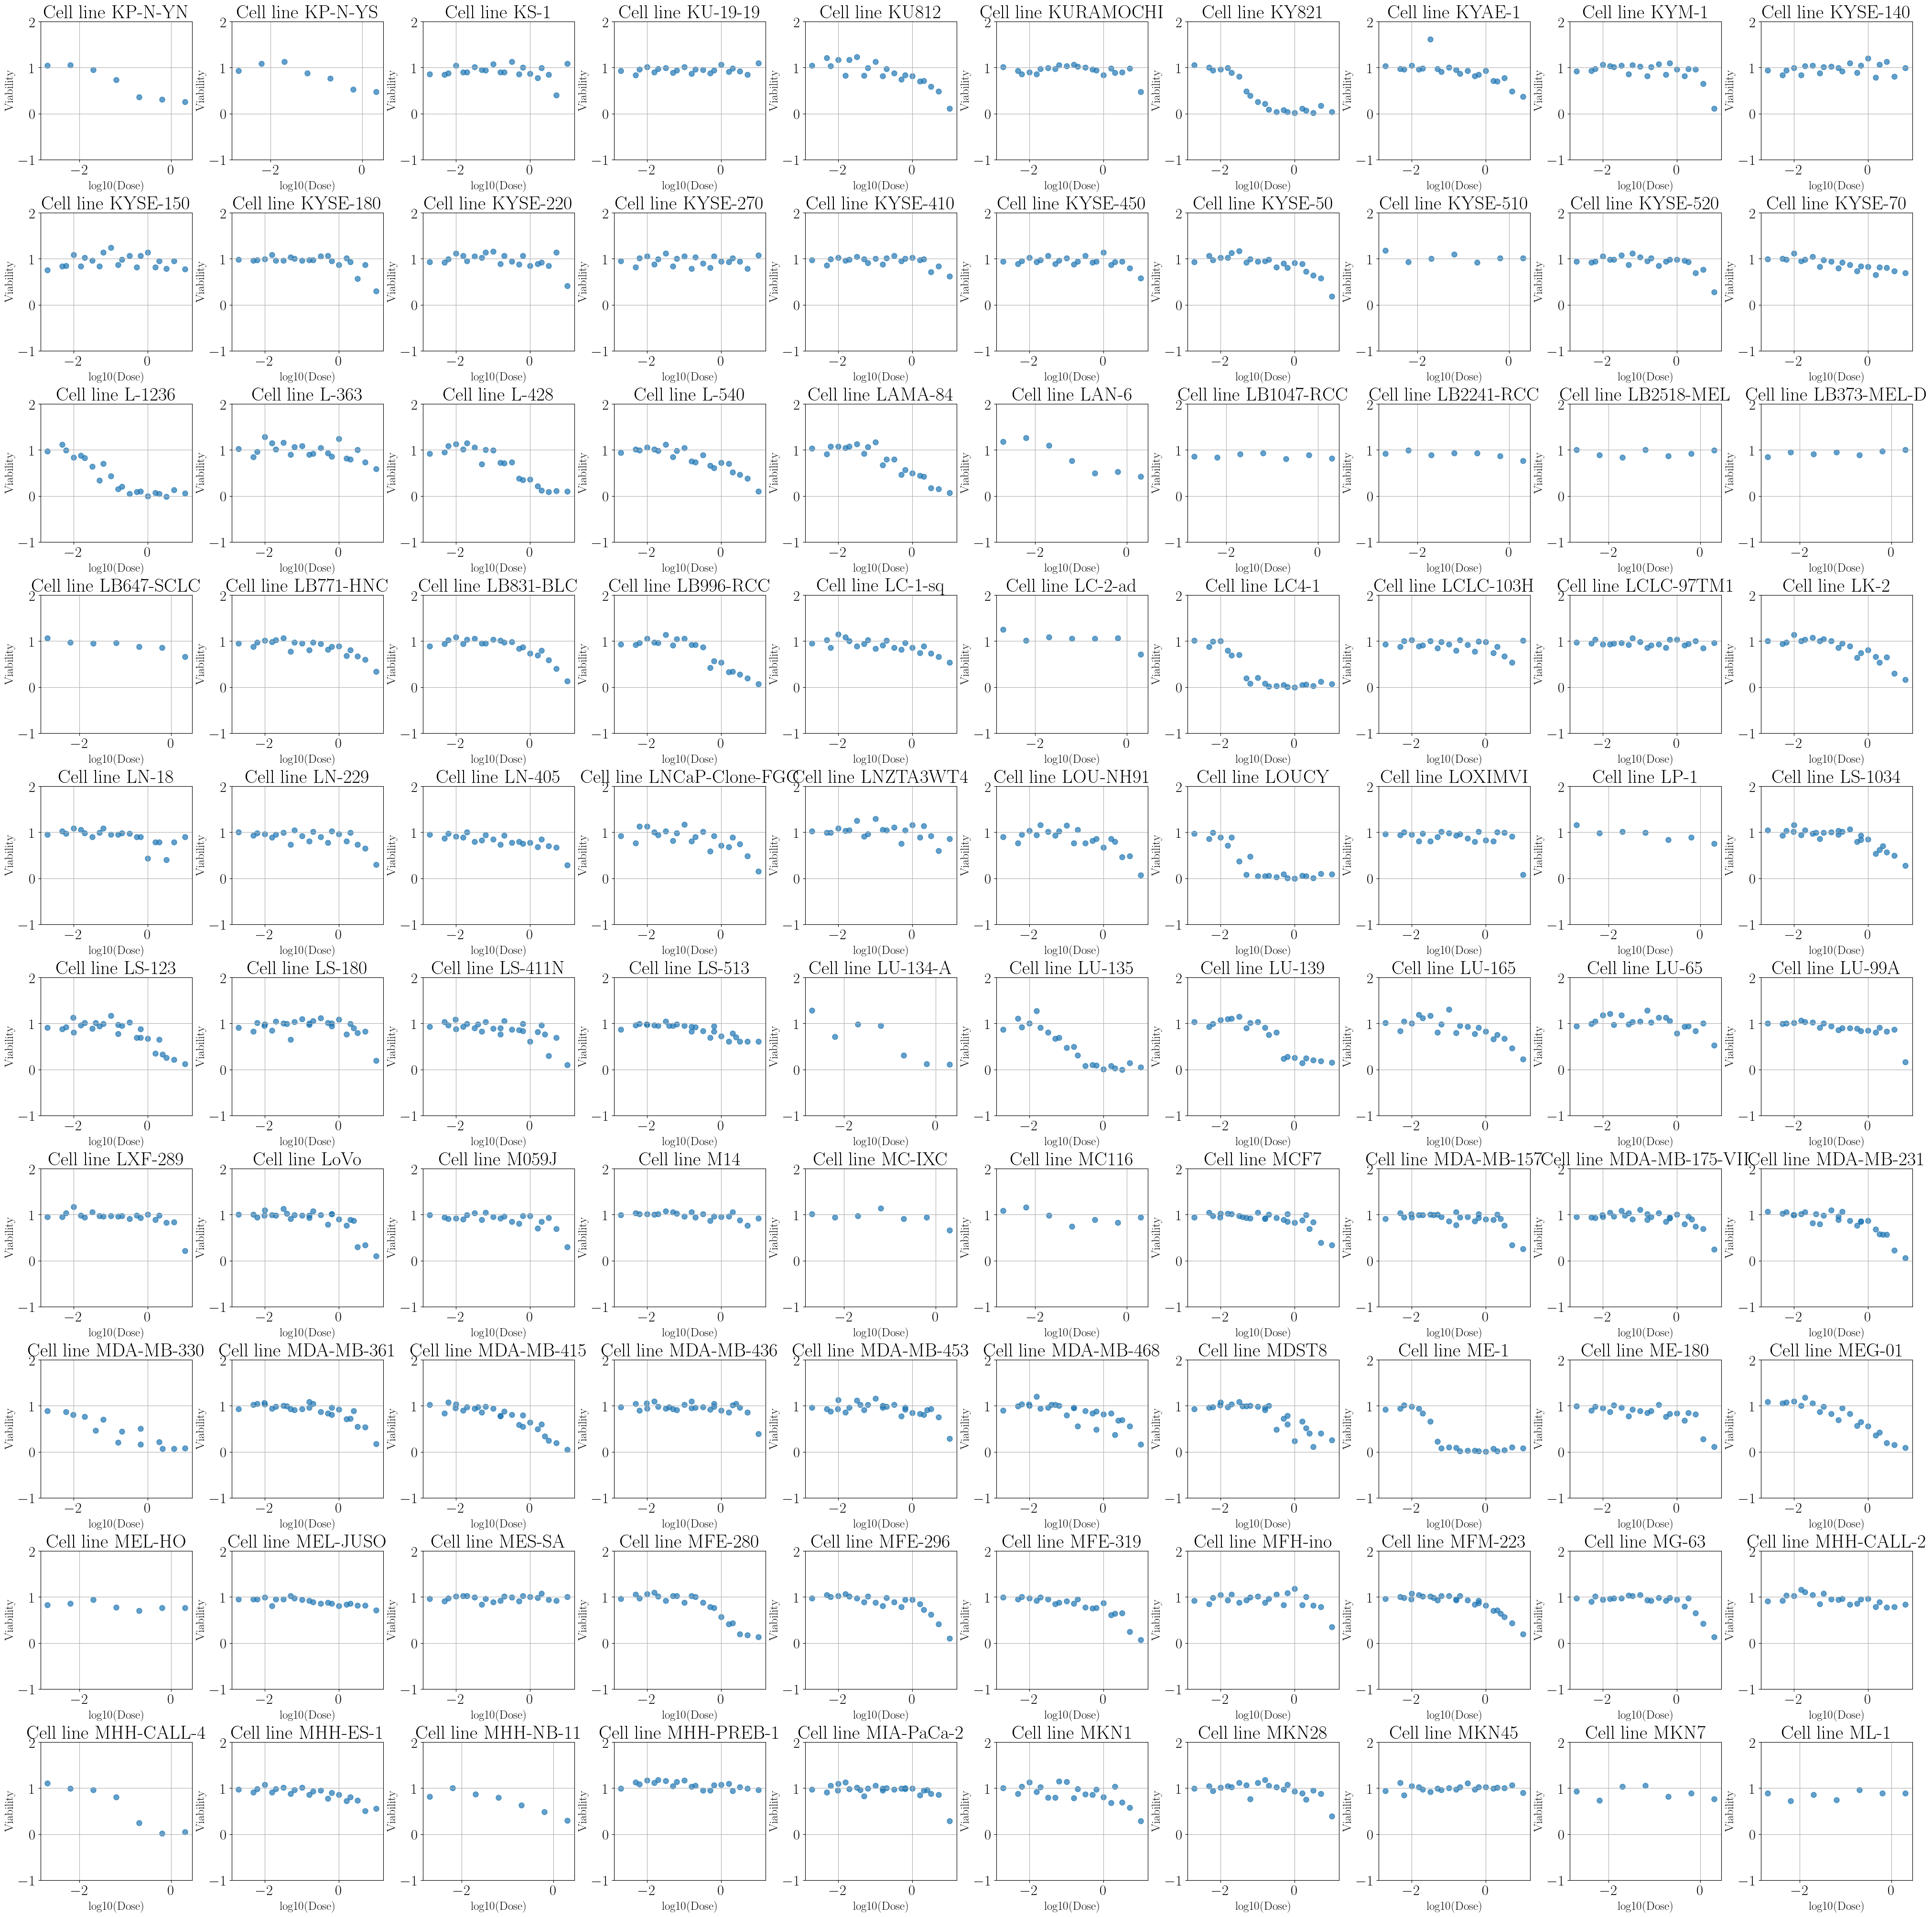

In [53]:
def visual_examples(df, k, begin_idx):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[begin_idx + i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Cell line {cell_line}')
                    #  , \n Name: {df_n["name"].iloc[0]}, \n Tissue: {df_n["tissue"].iloc[0]}', fontsize=16)
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(-1, 2)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 100, 400)

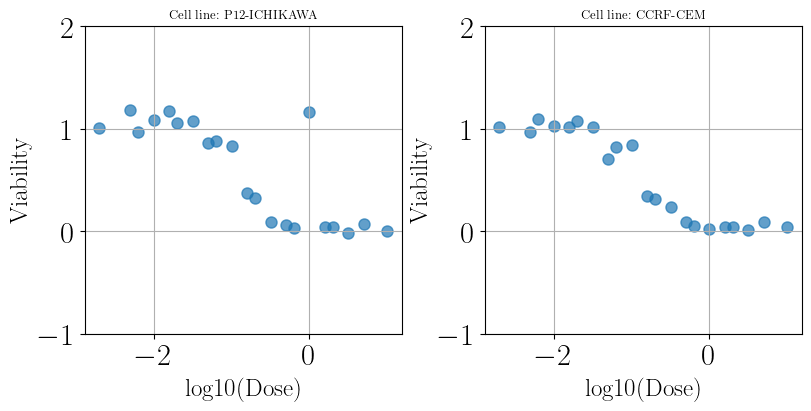

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_selected_cell_lines(df, cell_lines, max_plots=20):
    """
    Plots scatterplots for given cell lines, showing their name, tissue, and histology.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['cell_line', 'log10_dose', 'viability', 'tissue', 'histology'].
    cell_lines : list
        List of cell line identifiers (values from 'cell_line' column).
    max_plots : int, optional
        Maximum number of cell lines to plot (default=20).
    """
    # Filter the cell lines to those in the dataframe
    selected_lines = [cl for cl in cell_lines if cl in df['cell_line'].unique()]
    if not selected_lines:
        print("No matching cell lines found in dataframe.")
        return

    # Limit number of plots
    k = min(len(selected_lines), max_plots)

    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)
    axes = axes.flatten()

    for i, cell_line in enumerate(selected_lines[:k]):
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)

        # Extract metadata: take the first row for tissue/histology
        row_info = df_n.iloc[0]
        name = row_info['cell_line']
        # tissue = row_info['tissue']
        # histology = row_info['histology']

        # Multi-line title with smaller font
        title_text = f"Cell line: {name}"
        ax.set_title(title_text, fontsize=9, loc='center')

        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)
        ax.set_ylim(-1, 2)

    # Hide unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

chosen_cell_lines = ['P12-ICHIKAWA', 'CCRF-CEM', 'ARH-77']

plot_selected_cell_lines(df, chosen_cell_lines)

In [71]:
def preprocess_data(df, cell_lines):
    # Keep only the relevant columns
    df_copy = df[['cell_line', 'log10_dose', 'viability']]

    # Subset by the given cell_lines directly
    df_subset = df_copy[df_copy['cell_line'].isin(cell_lines)]

    # Pivot
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')

    # Reorder rows to match the order of `cell_lines` provided
    pivoted = pivoted.loc[cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

# list_cell_lines = ['P12-ICHIKAWA', 'CCRF-CEM', 'ARH-77']
list_cell_lines = ['P12-ICHIKAWA', 'CCRF-CEM']
list_cell_lines = ['P12-ICHIKAWA', 'ARH-77']
# list_cell_lines = ['P12-ICHIKAWA', 'CAL-120']
# list_cell_lines = ['P12-ICHIKAWA', 'UMC-11']
x, Y = preprocess_data(df, list_cell_lines)

In [6]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

def cov_to_corr(cov):
    stddev = np.sqrt(np.diag(cov))        # standard deviations
    corr = cov / np.outer(stddev, stddev) # normalize
    return corr

[[1.         0.97774873]
 [0.97774873 1.        ]]
[[0.22350222 0.18905707]
 [0.18905707 0.16728211]]
Optimized length_scale: 0.9562
Optimized noise: [0.06848085 0.01004386]
Optimized A: [[0.41295434 0.02621292]
 [0.41393798 0.05944572]]
Optimized B: 
[[0.17121841 0.17249573]
 [0.17249573 0.17487845]]
[[1.         0.99686188]
 [0.99686188 1.        ]]


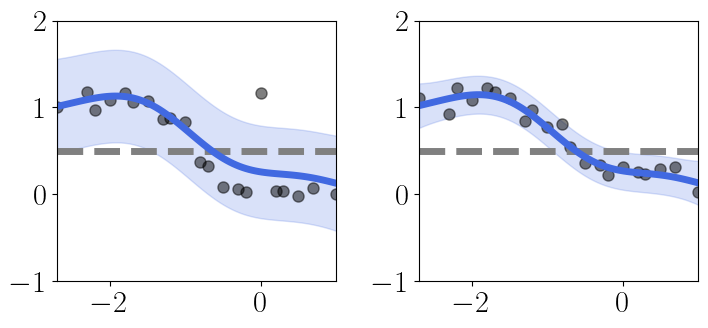

In [105]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.1
init_noise_var = np.array([0.005]*n_outputs) 
# init_A = generate_A(d=n_outputs, r=1, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.9).fit(Y_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)
empty_noise = np.array([1e-6]*n_outputs)
print(cov_to_corr(robust_covariance))
print(robust_covariance)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=robust_init_A)
# mogp = MOGPRegressor_NC(mean=prior_mean, length_scale=1.05, noise=0.005, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=True)
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.7, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

print(cov_to_corr(optim_B))

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4)) 

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([-1, 2])
    axs[i].set_xlim([x[0], x[-1]])
    # axs[i].set_yticks([0.5, 1])

    # if i == 0:
    #     axs[i].set_yticklabels(['0.5', '1']) 
    # else:
    #     axs[i].set_yticklabels([]) 

# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

[[1.         0.97774873]
 [0.97774873 1.        ]]
[[0.22350222 0.18905707]
 [0.18905707 0.16728211]]
Optimized length_scale: 1.7892
Optimized noise_var: [0.01058378 0.00624257]
Optimized A: [[ 6.55256734 10.71255573]
 [ 5.73609993  9.46078371]]
Optimized B: 
[[157.694989   138.93535383]
 [138.93535383 122.40927088]]


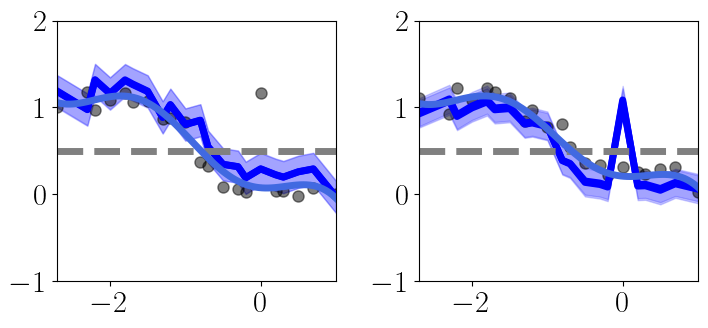

In [104]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.05
init_noise_var = np.array([0.005]*n_outputs)
epsilon = 0.5

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.9).fit(Y_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)
empty_noise = np.array([1e-6]*n_outputs)
print(cov_to_corr(robust_covariance))
print(robust_covariance)

morcgp = MORCGP(mean=prior_mean, length_scale=init_length_scale, noise_var=optim_noise, A=robust_init_A)
# init_gamma, init_c = morcgp.fit(x, Y, epsilons=np.array([3/9, 2/9]))
morcgp.fit(x, Y, epsilons=np.array([epsilon]*2))
init_gamma, init_c, gamma, c = morcgp.optimize_loo_cv(print_opt_param = True, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)

# Predict on test points
x_test = np.linspace(-2.7, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x.flatten(), gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), gamma[:, i] - c[:, i], gamma[:, i] + c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
    #                     color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([-1, 2])
    axs[i].set_xlim([x[0], x[-1]])
    # axs[i].set_yticks([0.5, 1])

    # if i == 0:
    #     axs[i].set_yticklabels(['0.5', '1'])
    # else:
    #     axs[i].set_yticklabels([])

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

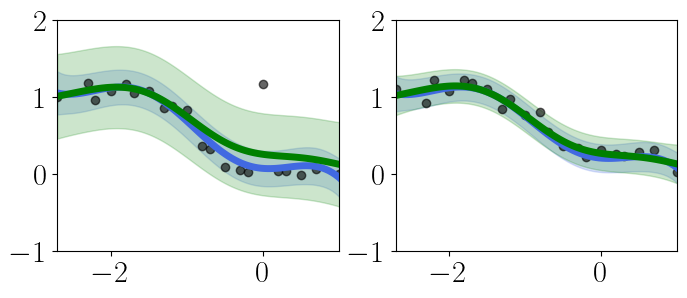

In [106]:
# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 3))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=6)

    # axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    

    # axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='green', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([-1, 2])
    axs[i].set_xlim([x[0], x[-1]])
    # axs[i].set_yticks([0.5, 1])

    # if i == 0:
    #     axs[i].set_yticklabels(['0.5', '1'])
    # else:
    #     axs[i].set_yticklabels([])

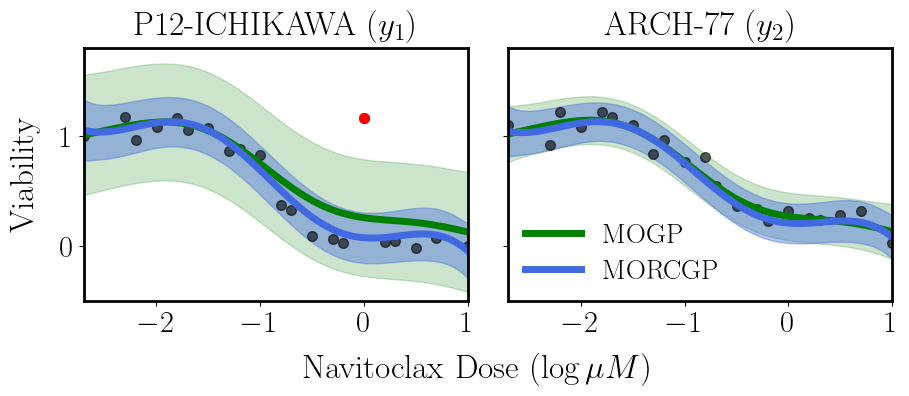

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(n_outputs):
    # Plotting data and predictions
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=7)
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_mogp[:, i] - 2*std_mogp[:, i],
                        mu_mogp[:, i] + 2*std_mogp[:, i],
                        color='green', alpha=0.2)
    
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MORCGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_morcgp[:, i] - 2*std_morcgp[:, i],
                        mu_morcgp[:, i] + 2*std_morcgp[:, i],
                        color='royalblue', alpha=0.4)

    # Axes limits
    axs[i].set_ylim([-0.5, 1.8])
    axs[i].set_xlim([x[0], x[-1]])

    # Titles and labels
    if i == 0:
        axs[i].set_title(r"P12-ICHIKAWA ($y_1$)", fontsize=24, pad=10)
        axs[i].set_ylabel("Viability", fontsize=24, labelpad=15)
    elif i == 1:
        axs[i].set_title(r"ARCH-77 ($y_2$)", fontsize=24, pad=10)
        axs[i].set_yticklabels([])
        axs[i].legend(loc='lower left', fontsize=20, frameon=False, borderpad=0.1, labelspacing=0.4)

    # **Thick borders (spines)**
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # change '3' to any thickness you want

# X-axis label
fig.text(0.55, -0.01, r'Navitoclax Dose $(\log\mu M)$', ha='center', fontsize=24)
axs[0].plot(x[15, 0], Y[15, 0], 'o', color='red', alpha=1, markersize=7)
plt.tight_layout()
plt.show()
fig.savefig("./navitoclax.pdf", format='pdf', bbox_inches='tight')